# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Laboratorio 7: Análisis de redes sociales

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169

**Curso:** Data Science  
**Sección:** 10  

---

Guatemala, 22 de septiembre de 2024


### 💻 Carga de la información

In [310]:
import json
import re
import nltk
import pandas as pd 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [311]:
with open('tioberny.txt', 'r', encoding='utf-16') as file:
    tweets = [json.loads(line) for line in file]

df_tweets = pd.DataFrame(tweets)
print(df_tweets)

                       id               id_str  \
0     1834281080029110288  1834281080029110288   
1     1834252464092069901  1834252464092069901   
2     1834280919336976681  1834280919336976681   
3     1834280512933732694  1834280512933732694   
4     1834279986254987428  1834279986254987428   
...                   ...                  ...   
5014  1832570119563743682  1832570119563743682   
5015  1832569640079270018  1832569640079270018   
5016  1832569563109896313  1832569563109896313   
5017  1832568528508968963  1832568528508968963   
5018  1832567980749660272  1832567980749660272   

                                                    url  \
0     https://x.com/La_ReVoluZzion/status/1834281080...   
1     https://x.com/XelaNewsGt/status/18342524640920...   
2     https://x.com/M24095273/status/183428091933697...   
3     https://x.com/carlosalbesc/status/183428051293...   
4     https://x.com/Brenda_AGN/status/18342799862549...   
...                                          

### 🧹 Limpieza y preprocesamiento de datos

Como parte inicial se decide eliminar columnas duplicadas de IDs. Además, se remueven columnas que cuentan en su mayoría con valores nulos ya que no aportan información de manera significativa respecto al total de datos. 

In [312]:
df_tweets.head(10)
df_tweets.columns

Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'bookmarkedCount', 'conversationId', 'conversationIdStr', 'hashtags',
       'cashtags', 'mentionedUsers', 'links', 'viewCount', 'retweetedTweet',
       'quotedTweet', 'place', 'coordinates', 'inReplyToTweetId',
       'inReplyToTweetIdStr', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', 'card', '_type'],
      dtype='object')

In [313]:
for i in ['id_str','url', 'conversationIdStr', 'inReplyToTweetIdStr']:
    if i in df_tweets.columns:
        df_tweets = df_tweets.drop(columns=['id_str','url', 'conversationIdStr', 'inReplyToTweetIdStr'])

In [314]:
df_tweets.head(10)
df_tweets[['_type']].nunique()

_type    1
dtype: int64

In [315]:
for i in ['id_str','url', 'conversationIdStr', 'inReplyToTweetIdStr', '_type']:
    if i in df_tweets.columns:
        df_tweets = df_tweets.drop(columns=['_type'])

In [316]:
df_tweets.head(10)
df_tweets[['card']]
df_tweets[['card']].count()

non_null_values = df_tweets['card'].dropna()
print(non_null_values)

11      {'title': '🔴 | El presidente @BArevalodeLeon p...
22      {'title': '🔴 | El presidente @BArevalodeLeon p...
33      {'title': '🔴 | El presidente @BArevalodeLeon p...
34      {'title': '🔴 | El presidente @BArevalodeLeon p...
136     {'title': 'Xela News (@xelanewsgt) • Instagram...
439     {'title': 'Fabiola Roudha interpreta el himno ...
483     {'title': 'Resumen de noticias – miércoles 11 ...
624     {'title': 'CC anula fallo que confirmó condena...
685     {'title': 'Ricardo Mendez Ruiz', 'description'...
749     {'title': 'MP busca retirar la inmunidad del p...
801     {'title': 'Arévalo comparte con pobladores de ...
882     {'title': 'MP busca retirar la inmunidad del p...
985     {'title': 'TikTok · Fernando Cajas', 'descript...
1012    {'title': 'Presidente resalta el valor de los ...
1134    {'title': 'Más de 9 mil familias con insegurid...
1245    {'title': 'El futuro del agua', 'description':...
1430    {'title': 'Presidente Arévalo resalta legado e...
1432    {'titl

In [317]:
if 'card' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['card'])

In [318]:
df_tweets.head(10)

,id,date,user,lang,rawContent,replyCount,retweetCount,likeCount,quoteCount,bookmarkedCount,...,retweetedTweet,quotedTweet,place,coordinates,inReplyToTweetId,inReplyToUser,source,sourceUrl,sourceLabel,media
0,1834281080029110288,2024-09-12 17:21:03+00:00,"{'id': 1435062946598694914, 'id_str': '1435062...",es,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",0,0,0,0,0,...,None,"{'id': 1834252464092069901, 'id_str': '1834252...",None,None,NaN,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
1,1834252464092069901,2024-09-12 15:27:20+00:00,"{'id': 956650778634145792, 'id_str': '95665077...",es,#URGENTE Lo que los medios #faferos no informa...,12,80,142,15,10,...,None,None,None,None,NaN,None,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [{'thumbnailUrl': 'ht..."
2,1834280919336976681,2024-09-12 17:20:25+00:00,"{'id': 1087057038755143680, 'id_str': '1087057...",es,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,0,0,0,0,0,...,None,None,None,None,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...","<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}"
3,1834280512933732694,2024-09-12 17:18:48+00:00,"{'id': 2881001877, 'id_str': '2881001877', 'ur...",es,@IvanDuque @BArevalodeLeon Entre Ellos se enti...,0,0,0,0,0,...,None,None,None,None,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
4,1834279986254987428,2024-09-12 17:16:42+00:00,"{'id': 3013862206, 'id_str': '3013862206', 'ur...",es,El presidente @BArevalodeLeon y la vicepreside...,0,0,0,0,0,...,None,None,None,None,NaN,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,{'photos': [{'url': 'https://pbs.twimg.com/med...
5,1834279973336875425,2024-09-12 17:16:39+00:00,"{'id': 1628956392487878657, 'id_str': '1628956...",es,@BArevalodeLeon El muy hijo de puta inyectó co...,0,0,0,0,0,...,None,None,None,None,1.833556e+18,"{'id': 945378369818058752, 'id_str': '94537836...","<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}"
6,1834279773021110367,2024-09-12 17:15:51+00:00,"{'id': 1456725120735748100, 'id_str': '1456725...",es,@EmisorasUnidas @BArevalodeLeon Y que de bueno...,0,0,0,0,0,...,None,None,None,None,1.834271e+18,"{'id': 40256008, 'id_str': '40256008', 'userna...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
7,1834279757351137308,2024-09-12 17:15:48+00:00,"{'id': 1049536922299846656, 'id_str': '1049536...",es,@IvanDuque @BArevalodeLeon Productiva es que g...,0,0,0,0,0,...,None,None,None,None,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
8,1834279356719661450,2024-09-12 17:14:12+00:00,"{'id': 145724847, 'id_str': '145724847', 'url'...",es,"@KarinHerreraVP El presidente de la República,...",0,0,0,0,0,...,None,None,None,None,1.834279e+18,"{'id': 145724847, 'id_str': '145724847', 'user...","<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [{'thumbnailUrl': 'ht..."
9,1834279190562308253,2024-09-12 17:13:32+00:00,"{'id': 749889296, 'id_str': '749889296', 'url'...",es,"@mys_servicios @BArevalodeLeon No tampoco, ese...",0,0,0,0,0,...,None,None,None,None,1.834265e+18,"{'id': 1101674869148798976, 'id_str': '11016

In [319]:
df_tweets[['coordinates']].count()
if 'coordinates' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['coordinates'])

In [320]:
df_tweets.head(10)
df_tweets[['lang']].count()
df_tweets[['lang']].nunique()

lang    20
dtype: int64

In [321]:
df_tweets[['place']].count()

on_null_values = df_tweets['place'].dropna()
print(non_null_values)

df_tweets[['place']].count()
if 'place' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['place'])

11      {'title': '🔴 | El presidente @BArevalodeLeon p...
22      {'title': '🔴 | El presidente @BArevalodeLeon p...
33      {'title': '🔴 | El presidente @BArevalodeLeon p...
34      {'title': '🔴 | El presidente @BArevalodeLeon p...
136     {'title': 'Xela News (@xelanewsgt) • Instagram...
439     {'title': 'Fabiola Roudha interpreta el himno ...
483     {'title': 'Resumen de noticias – miércoles 11 ...
624     {'title': 'CC anula fallo que confirmó condena...
685     {'title': 'Ricardo Mendez Ruiz', 'description'...
749     {'title': 'MP busca retirar la inmunidad del p...
801     {'title': 'Arévalo comparte con pobladores de ...
882     {'title': 'MP busca retirar la inmunidad del p...
985     {'title': 'TikTok · Fernando Cajas', 'descript...
1012    {'title': 'Presidente resalta el valor de los ...
1134    {'title': 'Más de 9 mil familias con insegurid...
1245    {'title': 'El futuro del agua', 'description':...
1430    {'title': 'Presidente Arévalo resalta legado e...
1432    {'titl

In [322]:
df_tweets.head(10)
if 'source' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['source'])

In [323]:
df_tweets.head(10)

,id,date,user,lang,rawContent,replyCount,retweetCount,likeCount,quoteCount,bookmarkedCount,...,mentionedUsers,links,viewCount,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,sourceUrl,sourceLabel,media
0,1834281080029110288,2024-09-12 17:21:03+00:00,"{'id': 1435062946598694914, 'id_str': '1435062...",es,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",0,0,0,0,0,...,"[{'id': 23664866, 'id_str': '23664866', 'usern...",[],NaN,None,"{'id': 1834252464092069901, 'id_str': '1834252...",NaN,None,http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
1,1834252464092069901,2024-09-12 15:27:20+00:00,"{'id': 956650778634145792, 'id_str': '95665077...",es,#URGENTE Lo que los medios #faferos no informa...,12,80,142,15,10,...,[],[],5200.0,None,None,NaN,None,https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [{'thumbnailUrl': 'ht..."
2,1834280919336976681,2024-09-12 17:20:25+00:00,"{'id': 1087057038755143680, 'id_str': '1087057...",es,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,0,0,0,0,0,...,"[{'id': 77653794, 'id_str': '77653794', 'usern...",[],NaN,None,None,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}"
3,1834280512933732694,2024-09-12 17:18:48+00:00,"{'id': 2881001877, 'id_str': '2881001877', 'ur...",es,@IvanDuque @BArevalodeLeon Entre Ellos se enti...,0,0,0,0,0,...,"[{'id': 77653794, 'id_str': '77653794', 'usern...",[],NaN,None,None,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
4,1834279986254987428,2024-09-12 17:16:42+00:00,"{'id': 3013862206, 'id_str': '3013862206', 'ur...",es,El presidente @BArevalodeLeon y la vicepreside...,0,0,0,0,0,...,"[{'id': 945378369818058752, 'id_str': '9453783...",[],7.0,None,None,NaN,None,http://twitter.com/download/android,Twitter for Android,{'photos': [{'url': 'https://pbs.twimg.com/med...
5,1834279973336875425,2024-09-12 17:16:39+00:00,"{'id': 1628956392487878657, 'id_str': '1628956...",es,@BArevalodeLeon El muy hijo de puta inyectó co...,0,0,0,0,0,...,"[{'id': 945378369818058752, 'id_str': '9453783...",[],3.0,None,None,1.833556e+18,"{'id': 945378369818058752, 'id_str': '94537836...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}"
6,1834279773021110367,2024-09-12 17:15:51+00:00,"{'id': 1456725120735748100, 'id_str': '1456725...",es,@EmisorasUnidas @BArevalodeLeon Y que de bueno...,0,0,0,0,0,...,"[{'id': 40256008, 'id_str': '40256008', 'usern...",[],3.0,None,None,1.834271e+18,"{'id': 40256008, 'id_str': '40256008', 'userna...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
7,1834279757351137308,2024-09-12 17:15:48+00:00,"{'id': 1049536922299846656, 'id_str': '1049536...",es,@IvanDuque @BArevalodeLeon Productiva es que g...,0,0,0,0,0,...,"[{'id': 77653794, 'id_str': '77653794', 'usern...",[],2.0,None,None,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
8,1834279356719661450,2024-09-12 17:14:12+00:00,"{'id': 145724847, 'id_str': '145724847', 'url'...",es,"@KarinHerreraVP El presidente de la República,...",0,0,0,0,0,...,"[{'id': 407880186, 'id_str': '407880186', 'use...",[],26.0,None,None,1.834279e+18,"{'id': 145724847, 'id_str': '145724847', 'user...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [{'thumbnailUrl': 'ht..."
9,1834279190562308253,2024-09-12 17:13:32+00:00,"{'id': 749889296, 'id_str': '749889296', 'url'...",es,"@mys_servicios @BArevalodeLeon No tampoco, ese...",0,0,0,0,0,...,"[{'id': 1101674869148798976, 'id_str': '110167...",[],2.0,None,None,1.834265e+18,"{'id': 1101674869148798976, 'id_str': '1101674...",http://twitter.com/download/iph

In [324]:
non_empty_count = df_tweets['cashtags'].apply(lambda x: len(x) > 0).sum()
print(f'Número de listas con al menos un valor: {non_empty_count}')

Número de listas con al menos un valor: 2


In [325]:
if 'cashtags' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['cashtags'])

In [326]:
print(f'Numero de retweets: {df_tweets["retweetedTweet"].sum()}')

Numero de retweets: 0


In [327]:
df_tweets[['retweetedTweet']].count()
if 'retweetedTweet' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['retweetedTweet'])

In [328]:
non_empty_count = df_tweets['links'].apply(lambda x: len(x) > 0).sum()
print(f'Número de listas con al menos un valor: {non_empty_count}')
if 'links' in df_tweets.columns:
    df_tweets = df_tweets.drop(columns=['links'])

Número de listas con al menos un valor: 120


Luego, centrandonos en la información del propio texto del tweet, se deciden realizar ciertas operaciones de limpieza que ayuden en el análisis de la información que este contiene. Las operaciones de limpieza que se realizaron sobre rawContent son:
- Convertir el texto a minúsculas (para asegurar la normalización de los hashtags y las menciones)
- Remover URLs
- Eliminar carácteres especiales.
- Reemplazar saltos de línea por espacios.
- Eliminar stopwords. 

In [329]:
# Crear una copia del DataFrame para trabajar sobre ella
df_tweets_cleaned = df_tweets.copy()

# 1. Convertir el texto a minúsculas
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].str.lower()


# 2. Quitar URLs
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

# 3. Eliminar caracteres especiales, preservando @ y #
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: re.sub(r'[^a-zA-Z0-9áéíóúñ@#\s]', '', x))

# 4. Reemplazar saltos de línea por espacios
df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(lambda x: x.replace('\n', ' ').replace('\r', ' '))

# 5. Eliminar stopwords
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))
def remove_stopwords(text):
    words = text.split()  
    filtered_words = [word for word in words if word not in spanish_stopwords] 
    return ' '.join(filtered_words)

df_tweets_cleaned['rawContent'] = df_tweets_cleaned['rawContent'].apply(remove_stopwords)

print(df_tweets_cleaned[['rawContent']].head())

                                          rawContent
0  confirmado compañeres impuesto @usembassyguate...
1  #urgente medios #faferos informaron ayer acerc...
2  @ivanduque @barevalodeleon usaste pegasus espi...
3  @ivanduque @barevalodeleon entienden bien cuad...
4  presidente @barevalodeleon vicepresidenta @kar...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daher\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Como las menciones fueron convertidas a minúsculas los usernames correspondientes también fueron convertidos a su versión minúscula para seguir la misma estructura. 

In [330]:
def process_user(user, property_name):
    if isinstance(user, dict) and property_name in user:
        user[property_name] = user[property_name].lower()
    return user

In [331]:
def process_user2(user, property_name):
    if user:
        if property_name in user['user']:
            user['user'][property_name] = user['user'][property_name].lower()
    return user

In [332]:
def process_user3(user, property_name):
    if user:
        for i in user:
            if isinstance(i, dict) and property_name in i:
                i[property_name] = i[property_name].lower()
    return user

In [333]:
df_tweets_cleaned['user'] = df_tweets_cleaned['user'].apply(lambda x: process_user(x, 'username'))
df_tweets_cleaned['inReplyToUser'] = df_tweets_cleaned['inReplyToUser'].apply(lambda x: process_user(x, 'username'))
df_tweets_cleaned['quotedTweet'] = df_tweets_cleaned['quotedTweet'].apply(lambda x: process_user2(x, 'username'))
df_tweets_cleaned['mentionedUsers'] = df_tweets_cleaned['mentionedUsers'].apply(lambda x: process_user3(x, 'username'))

In [334]:
def convert_hashtags_to_lowercase(hashtags):
    return [hashtag.lower() for hashtag in hashtags]

In [335]:
df_tweets_cleaned['hashtags'] = df_tweets_cleaned['hashtags'].apply(convert_hashtags_to_lowercase)

Además, en función del contenido existente en rawContent, se eliminan tweets que estén duplicados en el dataset. 

In [336]:
duplicated_count = df_tweets['rawContent'].duplicated().sum()
print(f'Número de tweets duplicados: {duplicated_count}')
df_tweets_cleaned = df_tweets_cleaned.drop_duplicates(subset=['rawContent'])

Número de tweets duplicados: 86


In [337]:
duplicated_count = df_tweets_cleaned['rawContent'].duplicated().sum()
print(f'Número de tweets duplicados: {duplicated_count}')

Número de tweets duplicados: 0


### 📚 Análisis exploratorio

Observando cómo se encuentra formada la información del usuario, menciones, retweets, respuestas entre otros. 

In [338]:
dfUser = df_tweets_cleaned[1:2]['user']
for i in dfUser:
    print(i)

{'id': 956650778634145792, 'id_str': '956650778634145792', 'url': 'https://x.com/XelaNewsGt', 'username': 'xelanewsgt', 'displayname': 'XelaNews', 'rawDescription': 'Noticias sin injerencias.', 'created': '2018-01-25 22:11:34+00:00', 'followersCount': 3462, 'friendsCount': 359, 'statusesCount': 2915, 'favouritesCount': 5717, 'listedCount': 3, 'mediaCount': 1132, 'location': 'Guatemala', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1795602273034199040/B_YZsc0K_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/956650778634145792/1704817554', 'protected': None, 'verified': False, 'blue': False, 'blueType': None, 'descriptionLinks': [], 'pinnedIds': [], '_type': 'snscrape.modules.twitter.User'}


In [339]:
dfInReplyToUser = df_tweets_cleaned[3:4]['inReplyToUser']
for i in dfInReplyToUser:
    print(i)

{'id': 77653794, 'id_str': '77653794', 'username': 'ivanduque', 'displayname': 'Iván Duque 🇨🇴', '_type': 'snscrape.modules.twitter.UserRef'}


In [340]:
dfMentionedUsers = df_tweets_cleaned[0:1]['mentionedUsers']
for i in dfMentionedUsers:
    for j in i:
        print(j)

{'id': 23664866, 'id_str': '23664866', 'username': 'usembassyguate', 'displayname': 'US Embassy Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 1001171061831020545, 'id_str': '1001171061831020545', 'username': '48cantonestoto', 'displayname': '48 Cantones Oficial', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 262691982, 'id_str': '262691982', 'username': 'usaidguate', 'displayname': 'USAID Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 1362391326, 'id_str': '1362391326', 'username': 'ueguatemala', 'displayname': 'Unión Europea en Guatemala', '_type': 'snscrape.modules.twitter.UserRef'}
{'id': 945378369818058752, 'id_str': '945378369818058752', 'username': 'barevalodeleon', 'displayname': 'Bernardo Arévalo', '_type': 'snscrape.modules.twitter.UserRef'}


In [341]:
dfQuotedTweet = df_tweets_cleaned[0:1]['quotedTweet']
for i in dfQuotedTweet:
    print(i)
    

{'id': 1834252464092069901, 'id_str': '1834252464092069901', 'url': 'https://x.com/XelaNewsGt/status/1834252464092069901', 'date': '2024-09-12 15:27:20+00:00', 'user': {'id': 956650778634145792, 'id_str': '956650778634145792', 'url': 'https://x.com/XelaNewsGt', 'username': 'xelanewsgt', 'displayname': 'XelaNews', 'rawDescription': 'Noticias sin injerencias.', 'created': '2018-01-25 22:11:34+00:00', 'followersCount': 3462, 'friendsCount': 359, 'statusesCount': 2915, 'favouritesCount': 5717, 'listedCount': 3, 'mediaCount': 1132, 'location': 'Guatemala', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1795602273034199040/B_YZsc0K_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/956650778634145792/1704817554', 'protected': None, 'verified': False, 'blue': False, 'blueType': None, 'descriptionLinks': [], 'pinnedIds': [], '_type': 'snscrape.modules.twitter.User'}, 'lang': 'es', 'rawContent': '#URGENTE Lo que los medios #faferos no informaron ayer, acerca de la

Después de la limpieza y filtrado de usuarios se observa que se cuenta con 4713 entradas en total.

In [342]:
df_tweets_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4713 entries, 0 to 5018
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                4713 non-null   int64  
 1   date              4713 non-null   object 
 2   user              4713 non-null   object 
 3   lang              4713 non-null   object 
 4   rawContent        4713 non-null   object 
 5   replyCount        4713 non-null   int64  
 6   retweetCount      4713 non-null   int64  
 7   likeCount         4713 non-null   int64  
 8   quoteCount        4713 non-null   int64  
 9   bookmarkedCount   4713 non-null   int64  
 10  conversationId    4713 non-null   int64  
 11  hashtags          4713 non-null   object 
 12  mentionedUsers    4713 non-null   object 
 13  viewCount         4635 non-null   float64
 14  quotedTweet       274 non-null    object 
 15  inReplyToTweetId  4072 non-null   float64
 16  inReplyToUser     4160 non-null   object 
 17  

In [343]:
df_tweets_cleaned.describe()

,id,replyCount,retweetCount,likeCount,quoteCount,bookmarkedCount,conversationId,viewCount,inReplyToTweetId
count,4.713000e+03,4713.000000,4713.000000,4713.000000,4713.000000,4713.000000,4.713000e+03,4.635000e+03,4.072000e+03
mean,1.832852e+18,6.377891,17.978358,91.542754,1.500530,4.066412,1.832311e+18,5.906320e+03,1.832954e+18
std,2.224593e+16,111.473081,253.094931,1785.949018,25.767564,105.225633,2.406518e+16,1.526856e+05,9.936211e+15
min,8.094212e+17,0.000000,0.000000,0.000000,0.000000,0.000000,8.094212e+17,1.000000e+00,1.257873e+18
25%,1.833205e+18,0.000000,0.000000,0.000000,0.000000,0.000000,1.832935e+18,8.000000e+00,1.832965e+18
50%,1.833599e+18,0.000000,0.000000,0.000000,0.000000,0.000000,1.833493e+18,2.400000e+01,1.833493e+18
75%,1.833911e+18,0.000000,0.000000,2.000000,0.000000,0.000000,1.833674e+18,8.100000e+01,1.833672e+18
max,1.834281e+18,4783.000000,8307.000000,67416.000000,1336.000000,5277.000000,1.834281e+18,8.495723e+06,1.834279e+18


Resulta interesante que del total de tweets, prácticamente la mitad son usuarios únicos por lo que se podría indicar que en promedio hay 2 tweets de cada usuario.

In [344]:
df_tweets_cleaned['user']
usersList = []
for i in df_tweets_cleaned['user']:
    usersList.append(i['username'])

print(f'Número de usuarios únicos: {len(set(usersList))}')

Número de usuarios únicos: 2541


La información obtenida del conteo de palabras más frecuentes obviando la de Guatemala, indica que el conjunto se centra en las decisiones del gobierno. En este caso la mayor frecuencia se centra en temas urgentes, el Ministerio Finanzas, el Diario de Centro América y principalemente en el presupuesto para el 2025.

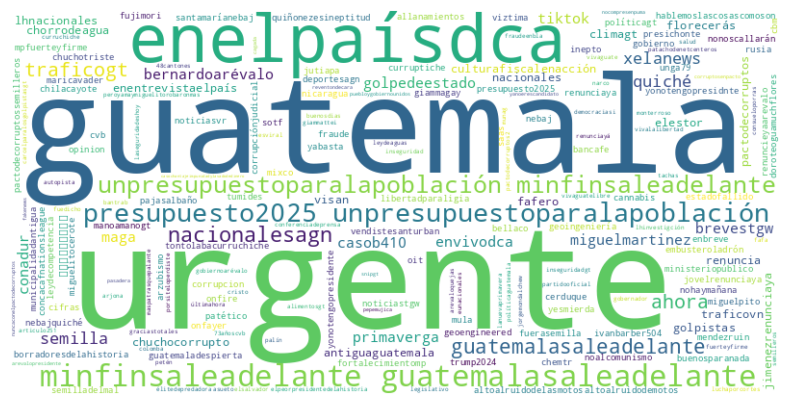

In [345]:
dfHashtags = df_tweets_cleaned[df_tweets_cleaned['hashtags'].apply(lambda x: len(x) > 0)]
hashtags = [hashtag for sublist in dfHashtags['hashtags'] for hashtag in sublist]
text = ' '.join(hashtags)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Observando la frecuencia de palabras en los tweets (tomando en cuenta todo el conjunto de palabras) se observa que todas hablan del propio presidente Bernardo Arévalo, así como todo lo relacionado al Gobierno de Guatemala.

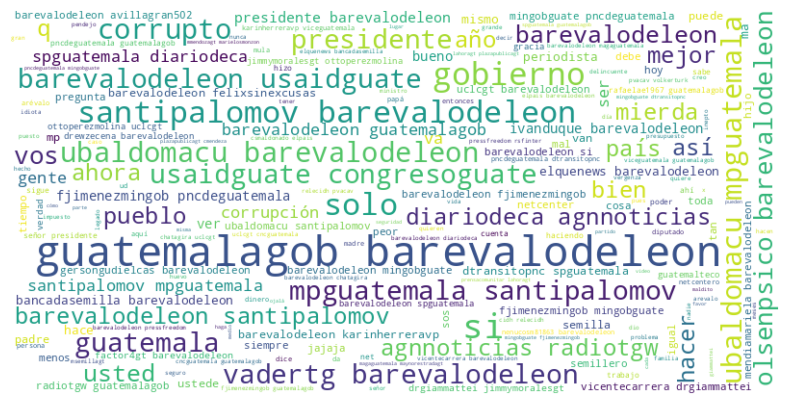

In [346]:
textTweets = ' '.join(df_tweets_cleaned['rawContent'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(textTweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [347]:
dfMentionedUsers = df_tweets[df_tweets['mentionedUsers'].apply(lambda x: len(x) > 0)]
dfMentionedUsers.head(10)

,id,date,user,lang,rawContent,replyCount,retweetCount,likeCount,quoteCount,bookmarkedCount,conversationId,hashtags,mentionedUsers,viewCount,quotedTweet,inReplyToTweetId,inReplyToUser,sourceUrl,sourceLabel,media
0,1834281080029110288,2024-09-12 17:21:03+00:00,"{'id': 1435062946598694914, 'id_str': '1435062...",es,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",0,0,0,0,0,1834281080029110288,[],"[{'id': 23664866, 'id_str': '23664866', 'usern...",NaN,"{'id': 1834252464092069901, 'id_str': '1834252...",NaN,None,http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
2,1834280919336976681,2024-09-12 17:20:25+00:00,"{'id': 1087057038755143680, 'id_str': '1087057...",es,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,0,0,0,0,0,1834197215415599186,[],"[{'id': 77653794, 'id_str': '77653794', 'usern...",NaN,None,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}"
3,1834280512933732694,2024-09-12 17:18:48+00:00,"{'id': 2881001877, 'id_str': '2881001877', 'ur...",es,@IvanDuque @BArevalodeLeon Entre Ellos se enti...,0,0,0,0,0,1834197215415599186,[],"[{'id': 77653794, 'id_str': '77653794', 'usern...",NaN,None,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
4,1834279986254987428,2024-09-12 17:16:42+00:00,"{'id': 3013862206, 'id_str': '3013862206', 'ur...",es,El presidente @BArevalodeLeon y la vicepreside...,0,0,0,0,0,1834279986254987428,[],"[{'id': 945378369818058752, 'id_str': '9453783...",7.0,None,NaN,None,http://twitter.com/download/android,Twitter for Android,{'photos': [{'url': 'https://pbs.twimg.com/med...
5,1834279973336875425,2024-09-12 17:16:39+00:00,"{'id': 1628956392487878657, 'id_str': '1628956...",es,@BArevalodeLeon El muy hijo de puta inyectó co...,0,0,0,0,0,1833556390192824324,[],"[{'id': 945378369818058752, 'id_str': '9453783...",3.0,None,1.833556e+18,"{'id': 945378369818058752, 'id_str': '94537836...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}"
6,1834279773021110367,2024-09-12 17:15:51+00:00,"{'id': 1456725120735748100, 'id_str': '1456725...",es,@EmisorasUnidas @BArevalodeLeon Y que de bueno...,0,0,0,0,0,1834271430994804795,[],"[{'id': 40256008, 'id_str': '40256008', 'usern...",3.0,None,1.834271e+18,"{'id': 40256008, 'id_str': '40256008', 'userna...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
7,1834279757351137308,2024-09-12 17:15:48+00:00,"{'id': 1049536922299846656, 'id_str': '1049536...",es,@IvanDuque @BArevalodeLeon Productiva es que g...,0,0,0,0,0,1834197215415599186,[],"[{'id': 77653794, 'id_str': '77653794', 'usern...",2.0,None,1.834197e+18,"{'id': 77653794, 'id_str': '77653794', 'userna...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}"
8,1834279356719661450,2024-09-12 17:14:12+00:00,"{'id': 145724847, 'id_str': '145724847', 'url'...",es,"@KarinHerreraVP El presidente de la República,...",0,0,0,0,0,1834276730984694160,[],"[{'id': 407880186, 'id_str': '407880186', 'use...",26.0,None,1.834279e+18,"{'id': 145724847, 'id_str': '145724847', 'user...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [{'thumbnailUrl': 'ht..."
9,1834279190562308253,2024-09-12 17:13:32+00:00,"{'id': 749889296, 'id_str': '749889296', 'url'...",es,"@mys_servicios @BArevalodeLeon No tampoco, ese...",0,0,0,0,0,1833556390192824324,[],"[{'id': 1101674869148798976, 'id_str': '110167...",2.0,None,1.834265e+18,"{'id': 1101674869148798976, 'id_str': '1101674...",http://twitter.com/download/iphone,Twitter for iPhone,"{'photos': [], 'videos': [], 'animated': []}"
10,1834279124082331958,2024-09-12 17:13:17+00:00,"{'id': 1562050217050005505, 'id_str': '1562050...",en,Happening Now: President @BA